# 이름 : 전상혁
# 학번 : 20163250
--------------
## Final Project 

### Project: Painting classification

### Due date: 2021.06.17

### 다음 링크로 접속하여 우선 팀 명을 바꿉니다. ex)20185141_용권순
https://www.kaggle.com/competitions/2022-deep-learning-basics-challenge

#### Data로 가서 Data를 모두 다운 받습니다. 그 다음은 Template code를 따라서 진행하시면 됩니다. 
>##### 최종실행 후  csv파일을 업로드 하시면 public결과가 보여집니다. 

---

* 아래 여러 셀에서 코드를 완성하는 부분을 수행하고, 보고서에 설명을 최대한 자세하게 적어주세요. 기준은 본인이 이해하고 있다는 것을 표현할 수 있는 부분을 모두 적으시면 됩니다.
  
  
> **제출방법**: 
* 보고서에는 코드 캡쳐 첨부이외에도, 각 코드를 작성하는 기반 이론, 방법론과 설명을 작성하세요.
---------------------------

## Final project 규칙

- 학생들 간의 질문은 금지합니다 (교수 및 조교에게 질문하세요)
- 대 원칙은 "내가 이해한 것만 활용하고 작성한다" 입니다
- 사용하는 기법들과 코드는 모두 보고서에 설명되어야하며, 설명이 없는 경우 감점이나 0점 처리합니다
    - 예를 들어서 검색한 끝에 model ensemble이라는 기법이 유용할 것 같아서, 참고하여 성능을 개선한 경우
        1. 참고자료의 출처를 작성할 것
        2. 기반 이론을 설명할 것
        3. 사용한 코드 분석 및 기법을 설명할 것
- 주석이 없는 경우 채점하지 않습니다
- <p style="color:red;">Pretrained network은 사용하지 않습니다. 본 프로젝트에서는, random 초기화한 parameter들을 직접 학습하는 과정만 허용합니다</p>

    - 랜덤 초기화 기법은 특별한 제약이 없습니다
- Competition 순위와 보고서는 각각 5:5로 점수가 반영됩니다.
------------------------

# 주의: 최종적으로 제출한 csv파일이 code에서 돌린 파일과 일치해야합니다. 
> + 기말 프로젝트 제출 시, model의 파라메터가 저장된 pt 파일, 보고서를 같이 제출합니다. 
> + 체점 과정 중 kaggle에 올라간 최종 csv파일과 제출한 모델을 사용하여 학생이 제출한 code로 csv생성 및 비교합니다(수기 변경 방지).
> + kaggle에 올라간 최종 csv파일과 학생이 제출한 code로 생성한 csv파일이 다를 경우 감점 요소가 생길 수 있으니 주의해주시길 바랍니다.

## 제출 하기 전 모든 셀을 정리해서 커널을 다시 실행하는 것을 권장 

---


# 배경 설명

> #### 여러분은 유명한 화가의 작품을 전시하는 유명한 미술관에 취업했습니다. 
>#### 최근 미술관이 대량의 작품을 입수하여, 각 화가들의 전시회를 열려고 합니다.   
>#### 그러나 작품의 수가 너무나 많아서 사람이 분류하기에는 시간이 오래 걸릴것이라고 판단됩니다. 
>#### 이에 여러분은 딥러닝을 사용하여 효율적인 화가별 그림 분류 프로그램을 만들고자 합니다.

# 목표: 
> ### 본 프로젝트의 완성본은, 새로운 그림(Image)입력하면 <p style="color:red">해당 그림을 그린 화가를 예측합니다.</p>



-------------------------------
------------------------------
-----------------------------

## Step 0: Import library

- 필요하다 생각되는 라이브러리를 미리 import합니다. (참고)
- 필요 없는 라이브러리를 제거하거나 필요한 라이브러리를 추가하셔도 됩니다.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from time import time, ctime, localtime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset,DataLoader

import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision import models


from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,train_test_split
from sklearn.model_selection import StratifiedKFold,  KFold


In [2]:
# CUDA 사용 가능한지 확인
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


-----------------------------------

## Step 1: Preparing Dataset 
### 1-1: 경로 설정

In [3]:
# # obtain one batch of training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(25, 4))
# # display 20 images
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
#     imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

In [4]:
#본인 컴퓨터에 맞는 train folder의 위치를 입력합니다.(string)
train_dir = '../input/2022-deep-learning-basics-challenge/painting_resize_256/train'   

In [5]:
# 폴더의 목록(화가의 이름)을 가지고 옵니다. 총 class : 15개  
classes = []
#class목록을 저장할 list 
for i in range(len(glob.glob(train_dir+'/*'))):
    classes.append(glob.glob(train_dir+'/*')[i].split('/')[-1])
class_num = len(classes)
print('Total Class num: ',class_num)
print('Class label:')
for i in range(class_num):print('{:5d}th : ' .format(i+1),classes[i])

Total Class num:  15
Class label:
    1th :  Jackson_Pollock
    2th :  Albrecht_Du_rer
    3th :  Rembrandt
    4th :  Vincent_van_Gogh
    5th :  Edouard_Manet
    6th :  Leonardo_da_Vinci
    7th :  Piet_Mondrian
    8th :  Francisco_Goya
    9th :  Edgar_Degas
   10th :  Pablo_Picasso
   11th :  Andy_Warhol
   12th :  Joan_Miro
   13th :  Pierre-Auguste_Renoir
   14th :  Claude_Monet
   15th :  Marc_Chagall


In [6]:
# #ABC 순서대로 정렬
# classes = sorted(classes)
# classes

### 1-2. 제대로 read 되는지 확인 (Transform적용)

In [7]:
#이미지 확인하기 위한 함수 정의
def check_Image(image_path,transform =None):
    image = Image.open(image_path).convert("RGB")
    if transform ==None:
        return image
    else: return transform(image)

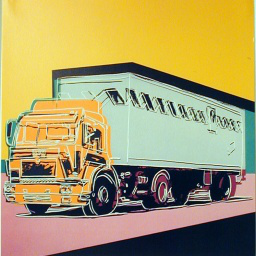

In [8]:
image = "../input/2022-deep-learning-basics-challenge/painting_resize_256/train/Andy_Warhol/Andy_Warhol_103.jpg"
check_Image(image)

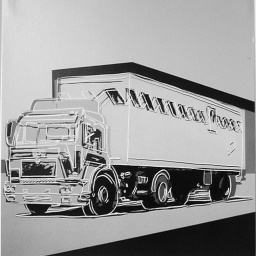

In [9]:
#image가 어떤 식으로 transform 되는지 확인하고 싶을 때 사용하시면 됩니다. 
transform = transforms.Compose([transforms.Grayscale(1)])
check_Image(image,transform)

## Step2: Generating DataLoader for Dataset

In [10]:
#train_transforms 규정
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #RGB color dataset 쓰기 때문에 각 채녈 마다 mean,std 적용
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 

train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
#classes ABC순으로 정렬 하기 위해 train_data.classes로 classes 정의
classes = train_data.classes

In [11]:
classes

['Albrecht_Du_rer',
 'Andy_Warhol',
 'Claude_Monet',
 'Edgar_Degas',
 'Edouard_Manet',
 'Francisco_Goya',
 'Jackson_Pollock',
 'Joan_Miro',
 'Leonardo_da_Vinci',
 'Marc_Chagall',
 'Pablo_Picasso',
 'Pierre-Auguste_Renoir',
 'Piet_Mondrian',
 'Rembrandt',
 'Vincent_van_Gogh']

--------------------------

In [12]:
# train, validation dataset spliting
# trainig dataset의 20%를 validation으로 사용
valid_size = 0.2

num_train = len(train_data) # train_data의 수
num_train = int(num_train) # integer로 변환
indices = list(range(num_train)) #0~3336 list
np.random.shuffle(indices) #list 값을 랜덤화 진행
split = int(np.floor(valid_size * num_train)) #split = 667

#train_idx -> 2670 valid_idx -> 667
train_idx, valid_idx = indices[split:], indices[:split]



# train sampler, valid sampler define
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
len(train_sampler)

2670

In [14]:
len(valid_sampler)

667

In [15]:
# batch size define
batch_size = 16

In [16]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)

In [17]:
len(train_loader)

167

In [18]:
len(valid_loader)

42

## Step 3: Generating Neural Network(model) 
 - <p style="color:red;">Pretrained network은 사용하지 않습니다. 본 프로젝트에서는, random 초기화한 parameter들을 직접 학습하는 과정만 허용합니다</p>
 - 모델을 선정한 이유를 간략하게 정리합니다.

In [19]:
# define the CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer (sees 3x256x256 image tensor)
        self.conv1 = nn.Conv2d(3,16,3,stride=1,padding=1)
        # convolutional layer (sees 16x128x128 tensor)
        self.conv2 = nn.Conv2d(16,32,3,stride=1,padding=1)
        # convolutional layer (sees 32x64x64 tensor)
        self.conv3 = nn.Conv2d(32,64,3,stride=1,padding=1)
        # convolutional layer (sees 64x32x32 tensor)
        self.conv4 = nn.Conv2d(64,128,3,stride=1,padding=1)
        # convolutional layer (sees 128x16x16 tensor)
        self.conv5 = nn.Conv2d(128,256,3,stride=1,padding=1)
        # convolutional layer (sees 256x8x8 tensor)
        self.conv6 = nn.Conv2d(256,512,3,stride=1,padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # linear layer (512 * 4 * 4 -> 400)
        self.fc1 = nn.Linear(512*4*4,400)

        self.fc2 = nn.Linear(400,15)
        
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(self.relu(self.conv1(x))) #torch.Size([16, 16, 128, 128])

        x = self.pool(self.relu(self.conv2(x))) #torch.Size([16, 32, 64, 64])

        x = self.pool(self.relu(self.conv3(x))) #torch.Size([16, 64, 32, 32])

        x = self.pool(self.relu(self.conv4(x))) #torch.Size([16, 128, 16, 16])
 
        x = self.pool(self.relu(self.conv5(x))) #torch.Size([16, 256, 8, 8])

        x = self.pool(self.relu(self.conv6(x))) #torch.Size([16, 512, 4, 4])

        # flatten image input
        x = x.reshape(-1,512*4*4)
        
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.relu(self.fc1(x))     
        
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = ConvNet()

# move tensors to GPU if CUDA is available
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=15, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU(inplace=True)
)

--------------------------

## Step 4: Selecting Cost(Loss) Function & Optimizer
> +  [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 및 [optimizer](http://pytorch.org/docs/stable/optim.html)를 선택하여 코드를 완성하세요.
  링크에서 다양한 Loss Function과 Optimize Function을 확인 할 수 있습니다

In [20]:
# loss function 지정(categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# optimizer 지정
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)

--------------------------

## Step 5: Train and validate the configured model
### 학습 및 검증 과정을 진행합니다
+ 학습 과정을 주석으로 설명하세요 
+ Epoch별로 Loss, Accuracy를 출력하여 학습 진행 과정을 확인 할 수 있도록 합니다
+ 출력 예시는 주어지나 정해진 형식은 없습니다
+ 최적의 모델 파라메터를 저장합니다.

For example : 
```python
Started Training...
Epoch: 1    Training Loss: 3.317162     Validation Loss: 4.162958
Epoch: 2    Training Loss: 2.420140     Validation Loss: 4.182362
...
...
Finished training
```

In [21]:
print('Started Training...')

# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in train_loader:
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
     # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'model_cov.pt')
        valid_loss_min = valid_loss[e]

print('Finished Training...')

Started Training...
Epoch: 0 	Training Loss: 2.437420 	Validation Loss: 2.302240
Epoch: 0 	Training accuracy: 0.195894 	Validation accuracy: 0.205357
Validation loss decreased (inf --> 2.302240).  Saving model ...
Epoch: 1 	Training Loss: 2.264988 	Validation Loss: 2.168957
Epoch: 1 	Training accuracy: 0.253529 	Validation accuracy: 0.286932
Validation loss decreased (2.302240 --> 2.168957).  Saving model ...
Epoch: 2 	Training Loss: 2.156456 	Validation Loss: 2.152743
Epoch: 2 	Training accuracy: 0.293467 	Validation accuracy: 0.309253
Validation loss decreased (2.168957 --> 2.152743).  Saving model ...
Epoch: 3 	Training Loss: 2.073055 	Validation Loss: 2.024483
Epoch: 3 	Training accuracy: 0.344686 	Validation accuracy: 0.342803
Validation loss decreased (2.152743 --> 2.024483).  Saving model ...
Epoch: 4 	Training Loss: 2.003651 	Validation Loss: 1.966023
Epoch: 4 	Training accuracy: 0.380133 	Validation accuracy: 0.365260
Validation loss decreased (2.024483 --> 1.966023).  Saving 

--------------------------

## Step 6: Analyze the  training/validation results
+ 위에서 구한 학습 결과를 분석합니다. 
+ 수업에서 배운 그래프를 활용하시는 것을 적극 추천드립니다.
+ 만족할만한 결과가 나올 때 까지 Hyper Parameter Tuning을 진행합니다. 

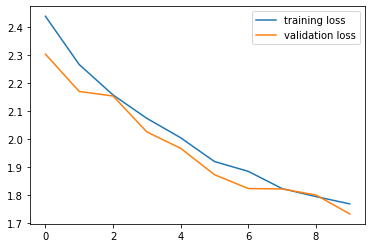

In [22]:
# loss graph 
plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

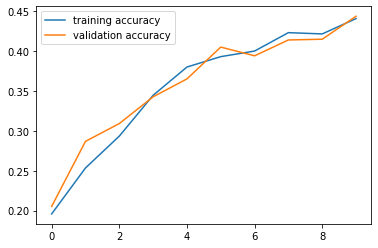

In [23]:
# accuracy graph
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

In [24]:
# save optimizer
torch.save(optimizer.state_dict(), 'opt_statedict.pt')

In [25]:
# save checkpoint
checkpoint = {'model_cov': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pt')

In [26]:
torch.save(model, 'model.pt')

--------------------------

## Step 7: Define Test Data Set
> Test data를 위한 Custom Test Dataset을 제공해드립니다.   
> 필요한 부분을 채워 사용하시거나 직접 코드를 작성하셔도 됩니다.

In [27]:
'''Custom Dataset을 제작하기 위해서는 3가지를 반드시 포함해야합니다. 
1.def __init__()      :초기화 함수입니다. Dataset을 상속받아 imagepath와 transform을 지정합니다.
2.def __len__()       :dataset의 총 길이를 return하는 함수입니다. 
3.def __getitem__()   :index(idx)에 해당하는 data sample을 return 하는 함수입니다. 
'''
class test_Dataset(Dataset): #test_set을 class로 정의합니다.
    def __init__(self,imgpath,transform=None):
        
        self.imgpath = imgpath
        self.transform = transform
        
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self,idx):
        if self.transform !=None:
            x = self.transform(Image.open(self.imgpath[idx]).convert('RGB'))
        else: x = Image.open(self.imgpath[idx]).convert('RGB')
        return x

In [28]:
test_dir = '../input/2022-deep-learning-basics-challenge/painting_resize_256/test'
#test_transform 정의 
test_transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_set  = sorted(glob.glob(test_dir+'/*')) #모든 파일을 읽어서 정리합니다. 
test_data = test_Dataset(test_set,test_transform)

#Data Loader 작성 , (tip: test이므로 Shuffle을 할 필요가 없습니다. )
test_Dataloader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [29]:
# test data 수 체크
print("test_data_len:", test_data.__len__())

test_data_len: 834


----------------

## Step 8(Final): Predict with Test Data
### Step 8-1: Predict 
+ test data를 우리의 모델로 예측합니다.

In [30]:
#class 재 확인 15개인지 확인하십시오 
print('Total Class num: ',class_num)
print('Class label:')
for i in range(class_num):print('{:5d}th : ' .format(i+1),classes[i])

Total Class num:  15
Class label:
    1th :  Albrecht_Du_rer
    2th :  Andy_Warhol
    3th :  Claude_Monet
    4th :  Edgar_Degas
    5th :  Edouard_Manet
    6th :  Francisco_Goya
    7th :  Jackson_Pollock
    8th :  Joan_Miro
    9th :  Leonardo_da_Vinci
   10th :  Marc_Chagall
   11th :  Pablo_Picasso
   12th :  Pierre-Auguste_Renoir
   13th :  Piet_Mondrian
   14th :  Rembrandt
   15th :  Vincent_van_Gogh


In [31]:
# 모델 불러오기
#최적의 모델 로드해서 predict를 진행합니다.

model.load_state_dict(torch.load('model_cov.pt'))
model.eval()

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=15, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU(inplace=True)
)

In [32]:
# obtain one batch of test images
dataiter = iter(test_Dataloader)
images = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

In [33]:
#pred 확인
pred

array([14,  9,  0, 14, 14, 10,  0,  3, 13,  3, 13,  3,  0, 13, 10, 14,  3,
        3, 14,  3,  3,  3, 10,  3,  3,  3, 14,  0,  9, 14,  9,  0, 14,  3,
       14, 14, 14,  5, 10, 10,  3,  3,  9, 13, 14, 14,  0,  9, 14, 13, 14,
        9,  9,  0,  3, 14,  9, 14, 14, 13,  3, 14, 14, 10, 14,  9,  3,  5,
       10,  3, 10,  3,  3, 14, 10,  9, 13,  3,  3, 10,  3,  0,  3,  3, 13,
       14,  3,  5,  3, 10,  3,  0,  0, 14, 10, 14,  9,  3,  3, 14,  3, 13,
        0,  3, 14, 10,  0,  3,  5, 10,  3, 14, 14,  3, 10,  3,  3,  0,  9,
        3,  3, 14, 14, 14,  3, 14, 14,  0, 14, 10,  3, 14, 10,  3,  9, 10,
       14, 14,  5,  3,  0, 14,  0, 14,  3, 14,  3, 10,  0, 13, 10, 14, 14,
       10, 11,  3, 14,  3, 10, 14, 10,  0, 10,  0,  1, 14,  3, 10,  3,  0,
       13,  0, 10,  0,  3, 14,  3, 14,  9, 14,  3, 14,  9, 14,  3, 14,  3,
       14, 14, 14,  9, 14,  3, 13,  3, 14, 10, 13,  3,  3, 10, 10, 14,  9,
       10,  3, 10, 14,  0, 14, 13,  3, 14,  9,  3,  3, 14,  3,  0,  0,  5,
        0, 11, 14,  5, 14

### Step 8-2 : Making csv file with our predict result
+ csv파일로 만드는 예시를 보여드립니다. 

In [34]:
name=[]                                     # 그림의 Id를 담을 list 생성 
category =[]                                # 그림의 Category를 담을 list 생성
for i in range(test_data.__len__()):        #
    name.append(test_set[i].split('/')[-1]) # 파일 이름에서 label만 가지고 옵니다. 
    category.append(classes[pred[i]])       # pred에 해당하는 class를 category에 집어 넣습니다. 
    
    
tm = localtime()
csv_file_name = f"{tm.tm_mday}day_{tm.tm_hour}h_{tm.tm_min}m_{tm.tm_sec}s"

#파일의 이름은 마음대로 설정할 수 있습니다. 경로를 쓰지 않으면 현재 디렉토리에 알아서 생성됩니다. 
pd.DataFrame({'Id':name,'Category':category}).to_csv(f'predict_{csv_file_name}.csv',index=False)                                                

In [35]:
#predict 하기 위해서 model 전체를 저장합니다. 체점을 위해서 필요한 과정입니다.
torch.save(model,f'./pt/model_{csv_file_name}.pt') 

FileNotFoundError: [Errno 2] No such file or directory: './pt/model_19day_5h_44m_40s.pt'

In [ ]:
print(name[:5])
print(category[:5])

In [ ]:
# 잘 생성됬는지 확인 , 따로 경로를 설정하지 않았다면,현재 디렉토리에 자동으로 생성됩니다. 
pd.read_csv(f'./predict_{csv_file_name}.csv')

## 생성한 csv파일을 kaggle에 등록하시면 됩니다.

